### Importing libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D




### Data Pre-Processing

In [5]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)


['./dataset/ModerateDemented/30.jpg',
 './dataset/ModerateDemented/29.jpg',
 './dataset/ModerateDemented/28.jpg',
 './dataset/ModerateDemented/32 (2).jpg',
 './dataset/ModerateDemented/27 (2).jpg',
 './dataset/ModerateDemented/31.jpg',
 './dataset/ModerateDemented/32.jpg',
 './dataset/ModerateDemented/30 (2).jpg',
 './dataset/ModerateDemented/29 (2).jpg',
 './dataset/ModerateDemented/27.jpg',
 './dataset/ModerateDemented/28 (2).jpg',
 './dataset/ModerateDemented/31 (2).jpg',
 './dataset/NonDemented/31 (51).jpg',
 './dataset/NonDemented/30 (84).jpg',
 './dataset/NonDemented/28 (25).jpg',
 './dataset/NonDemented/31 (100).jpg',
 './dataset/NonDemented/28 (28).jpg',
 './dataset/NonDemented/32 (63).jpg',
 './dataset/NonDemented/32 (65).jpg',
 './dataset/NonDemented/30 (31).jpg',
 './dataset/NonDemented/26 (92).jpg',
 './dataset/NonDemented/32 (32).jpg',
 './dataset/NonDemented/29 (32).jpg',
 './dataset/NonDemented/28 (98).jpg',
 './dataset/NonDemented/28 (92).jpg',
 './dataset/NonDemented/2

In [6]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [7]:
#Image Augmentation to increase samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


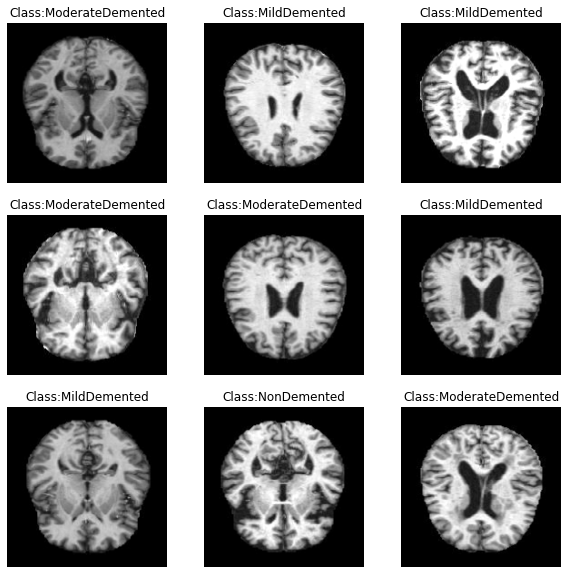

In [8]:
def show_images(generator,y_pred=None):
    
    labels =dict(zip([0,1,2,3], CLASSES))
    x,y = generator.next()
    
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
show_images(train_data_gen)

In [9]:
train_data, train_labels = train_data_gen.next()

In [10]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [11]:
#over-sampling of the data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [12]:
#Split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### InceptionV3

In [13]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [14]:
for layer in inception_model.layers:
    layer.trainable=False

In [15]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")
for layer in inception_model.layers:
    layer.trainable=False
    
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [16]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("ternimate on reaching 99%")
            self.model.stop_training = True
            
my_callback = MyCallback()

rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [17]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_188 (Bat (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_189 (Bat (None, 512)       

In [18]:
EPOCHS = 25

history = custom_inception_model.fit(train_data, train_labels, 
                                     validation_data=(val_data, val_labels), 
                                     callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/25
256/256 [==============================] - 24s 60ms/step - loss: 1.6197 - acc: 0.3355 - auc: 0.5963 - f1_score: 0.3341 - val_loss: 0.8344 - val_acc: 0.6099 - val_auc: 0.8712 - val_f1_score: 0.5552
Epoch 2/25
256/256 [==============================] - 13s 51ms/step - loss: 0.9860 - acc: 0.5416 - auc: 0.8215 - f1_score: 0.5368 - val_loss: 0.6689 - val_acc: 0.6880 - val_auc: 0.9157 - val_f1_score: 0.6665
Epoch 3/25
256/256 [==============================] - 13s 51ms/step - loss: 0.8024 - acc: 0.6283 - auc: 0.8815 - f1_score: 0.6245 - val_loss: 0.6077 - val_acc: 0.7349 - val_auc: 0.9336 - val_f1_score: 0.7298
Epoch 4/25
256/256 [==============================] - 13s 51ms/step - loss: 0.7266 - acc: 0.6600 - auc: 0.9019 - f1_score: 0.6525 - val_loss: 0.5639 - val_acc: 0.7412 - val_auc: 0.9421 - val_f1_score: 0.7386
Epoch 5/25
256/256 [==============================] - 13s 51ms/step - loss: 0.7040 - acc: 0.6902 - auc: 0.9105 - f1_score: 0.6910 - val_loss: 0.5247 - val_acc: 0.7773 -

### Results


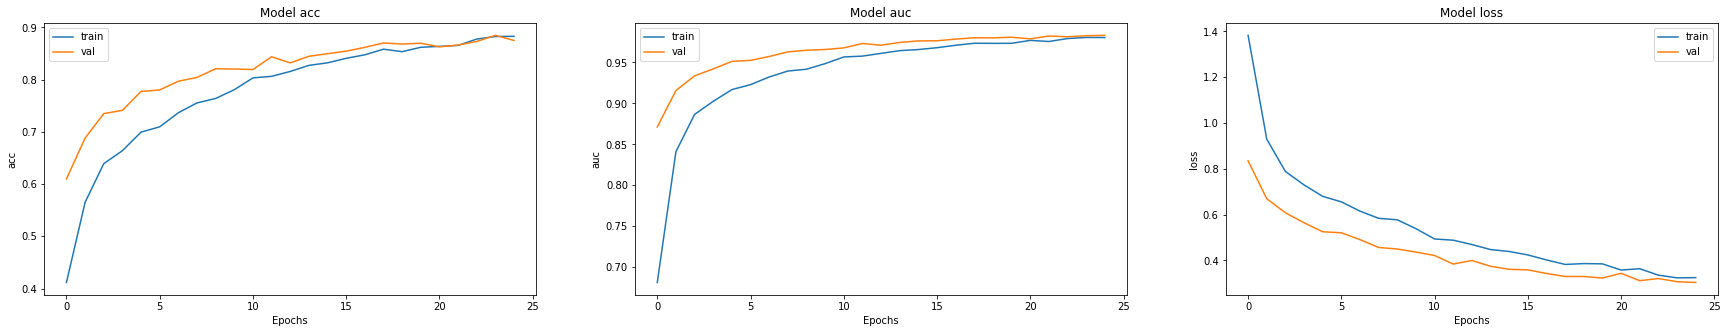

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [20]:
#Evaluating model

test_scores = custom_inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 3s 39ms/step - loss: 0.3292 - acc: 0.8687 - auc: 0.9801 - f1_score: 0.8671
Testing Accuracy: 86.87%


In [21]:
#Predicting the test data

pred_labels = custom_inception_model.predict(test_data)

In [22]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.88      0.95      0.91       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.79      0.81      0.80       662
ModerateDemented       0.80      0.71      0.75       624

       micro avg       0.87      0.87      0.87      2560
       macro avg       0.87      0.87      0.87      2560
    weighted avg       0.87      0.87      0.87      2560
     samples avg       0.87      0.87      0.87      2560



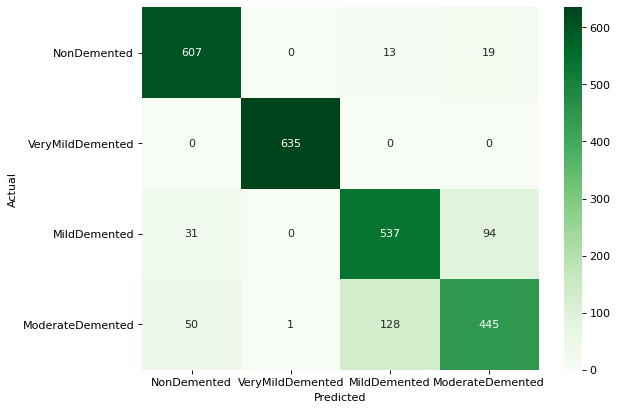

In [23]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show(ax)

In [24]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 86.86 %
Matthew's Correlation Coefficient: 82.55 %
